## 12: Hierarchical 2SFCA for Equitable Access to Care

**Goal:** To model healthcare accessibility by accounting for both resource competition (supply vs. demand) and the need to match patients with an appropriate level of care. This moves beyond simple travel time to a more nuanced measure of service equity.

**Methodology:**
We will implement the **Hierarchical Two-Step Floating Catchment Area (H-2SFCA)** method.
1.  **Define Service Tiers:** Assign capabilities to our facility hierarchy (GP, Community, Acute).
2.  **Step 1 (Supply-Side):** For each facility, calculate its provider-to-population ratio within its service area.
3.  **Step 2 (Demand-Side):** For each residential area (LSOA), sum the ratios of all *appropriate* facilities it can reach.
4.  **Visualize Tiered Access:** Create separate maps for Primary, Community, and Acute care accessibility to identify different types of healthcare deserts.

### 1. Setup and Library Imports

### 2. Load and Prepare Data

We need a facility hierarchy, demand points (LSOAs with population), and a street network.

### 3. Implement the Hierarchical 2SFCA Method

We'll create a function to run the 2SFCA for a given service tier and travel time.

### 4. Visualize Tiered Accessibility

We create a separate choropleth map for each care tier. This allows us to see how different types of healthcare access vary across the city.

### 5. Analysis and Conclusion

The 2SFCA method provides a much richer understanding of accessibility than travel time alone.

- **Reveals Hidden Disparities:** An area might appear to have good access because it's close to a facility (low travel time), but if that facility is overwhelmed with demand from a large population, the actual accessibility is low. The 2SFCA score captures this.
- **Highlights Different 'Deserts':** The maps clearly show that an area can be a 'desert' for one type of care but not another. For example, a suburban area might have excellent access to GP practices (Map A) but very poor access to specialized acute care (Map C).
- **Informs Systemic Planning:** This analysis is vital for health service planners. It helps identify not just where to put new facilities, but *what kind* of facilities are needed most in specific areas to ensure equitable access across all tiers of care.

### 6. References and Further Reading

- **Luo, W., & Wang, F. (2003).** *Measures of spatial accessibility to health care in a GIS environment: synthesis and a case study in the Chicago region*. Environment and Planning B: Planning and Design, 30(6), 865-884. One of the foundational papers on the 2SFCA method.
- **Zhao, Y., & Zhou, Y. (2024).** *Isochrone-Based Accessibility Analysis of Pre-Hospital Emergency Medical Facilities*. ISPRS Int. J. Geo-Inf. The concept of assessing equity from the demand side by considering resource competition is central to this paper and the 2SFCA method.
- **Hierarchical Models:** The idea of modeling different tiers of service is common in healthcare and retail analysis. It recognizes that services are not uniform and that higher-order services are typically less numerous and have larger catchment areas.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Point, box
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
ox.settings.log_console=True
ox.settings.use_cache=True
print("Libraries loaded.")


Libraries loaded.


In [2]:
# --- 1. Facility Data with Hierarchy and Capacity ---
facilities_data = {
    'Royal Devon and Exeter (Acute)': [-3.503, 50.713, 3, 50],  # [lon, lat, tier, capacity]
    'Exeter Community Hospital':      [-3.518, 50.718, 2, 20],
    'Heavitree Hospital (CDC)':       [-3.495, 50.720, 2, 25],
    'St. Thomas Medical Group (GP)':  [-3.542, 50.717, 1, 5],
    'Pinhoe & Broadclyst Medical (GP)':[-3.475, 50.741, 1, 6],
    'Ide Lane Surgery (GP)':          [-3.545, 50.705, 1, 4],
    'Topsham Surgery (GP)':           [-3.468, 50.682, 1, 3]
}
df = pd.DataFrame.from_dict(facilities_data, orient='index',
                            columns=['lon', 'lat', 'tier', 'capacity'])
facilities_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)

# --- 2. Demand Data (LSOAs with Population) ---
xmin, ymin, xmax, ymax = -3.58, 50.68, -3.42, 50.78  # Bounding box for Exeter
grid_cells = []
steps = 15
cell_w = (xmax - xmin) / steps
cell_h = (ymax - ymin) / steps
for i, x in enumerate(np.linspace(xmin, xmax-cell_w, steps)):
    for j, y in enumerate(np.linspace(ymin, ymax-cell_h, steps)):
        grid_cells.append(box(x, y, x + cell_w, y + cell_h))
lsoa_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:4326")
lsoa_gdf['LSOA_ID'] = range(len(lsoa_gdf))
np.random.seed(42)
lsoa_gdf['population'] = np.random.randint(1500, 2500, size=len(lsoa_gdf))
# Centroids as demand points
demand_points = lsoa_gdf.copy()
demand_points['geometry'] = demand_points.centroid

print("Facilities:", len(facilities_gdf), "| LSOA demand points:", len(demand_points))


Facilities: 7 | LSOA demand points: 225


In [3]:
# --- 3. Street Network ---
place_name = "Exeter, England, United Kingdom"
G = ox.graph_from_place(place_name, network_type='drive')
# Quick summary compatible with NetworkX 3.x
print(f"MultiDiGraph with {G.number_of_nodes():,} nodes and {G.number_of_edges():,} edges")

# --- 3a. Add travel time (seconds) to each edge ---
def add_travel_time(G, freeflow_kph=50):
    G = G.copy()
    meters_per_km = 1000
    for u, v, k, data in G.edges(keys=True, data=True):
        length_m = data.get("length", 0)
        speed_kph = data.get("speed_kph", freeflow_kph)
        # convert to travel time in seconds
        data["travel_time"] = (length_m / meters_per_km) / speed_kph * 3600
    return G

G_time = add_travel_time(G)


MultiDiGraph with 5,343 nodes and 11,390 edges


In [4]:
# --- 4. Helper: Build isochrone polygon ---
import geopandas as gpd
from shapely.geometry import MultiPoint

def make_iso_polygon(G, center_node, trip_seconds, weight='travel_time'):
    """Return a convex-hull polygon of all nodes reachable within trip_seconds."""
    # Dijkstra search
    reach = nx.single_source_dijkstra_path_length(G, center_node, trip_seconds, weight=weight)
    if not reach:
        return None
    # collect reachable node coordinates
    node_points = [Point((G.nodes[n]['x'], G.nodes[n]['y'])) for n in reach.keys()]
    # create convex hull polygon
    poly = MultiPoint(node_points).convex_hull
    return poly
print("Isochrone helper ready.")


Isochrone helper ready.


In [5]:
# --- 5. Hierarchical 2SFCA implementation ---
def run_2sfca(facilities, demand, G, travel_time_min, service_tier):
    """Run a simple 2‑step floating catchment analysis for the given tier."""
    travel_seconds = travel_time_min * 60
    weight = 'travel_time'

    # 1. Provider‑to‑population ratios (PPR)
    fac_subset = facilities[facilities['tier'] >= service_tier].copy()
    ppr_vals = []
    for idx, fac in fac_subset.iterrows():
        center = ox.nearest_nodes(G, fac.geometry.x, fac.geometry.y)
        poly = make_iso_polygon(G, center, travel_seconds, weight)
        if poly is None:
            ppr_vals.append(0)
            continue
        # demand points in polygon
        covered = demand[demand.within(poly)]
        pop = covered['population'].sum()
        ppr = fac['capacity'] / pop if pop > 0 else 0
        ppr_vals.append(ppr)
    fac_subset = fac_subset.assign(ppr=ppr_vals)

    # 2. Accessibility score for each demand point
    scores = []
    for idx, dem in demand.iterrows():
        center = ox.nearest_nodes(G, dem.geometry.x, dem.geometry.y)
        poly = make_iso_polygon(G, center, travel_seconds, weight)
        if poly is None:
            scores.append(0)
            continue
        fac_in_reach = fac_subset[fac_subset.within(poly)]
        scores.append(fac_in_reach['ppr'].sum())
    return scores

# Compute accessibility for each tier
lsoa_gdf['access_primary']   = run_2sfca(facilities_gdf, demand_points, G_time, 10, service_tier=1)
lsoa_gdf['access_community'] = run_2sfca(facilities_gdf, demand_points, G_time, 20, service_tier=2)
lsoa_gdf['access_acute']     = run_2sfca(facilities_gdf, demand_points, G_time, 30, service_tier=3)
print("Accessibility scores computed.")


Accessibility scores computed.


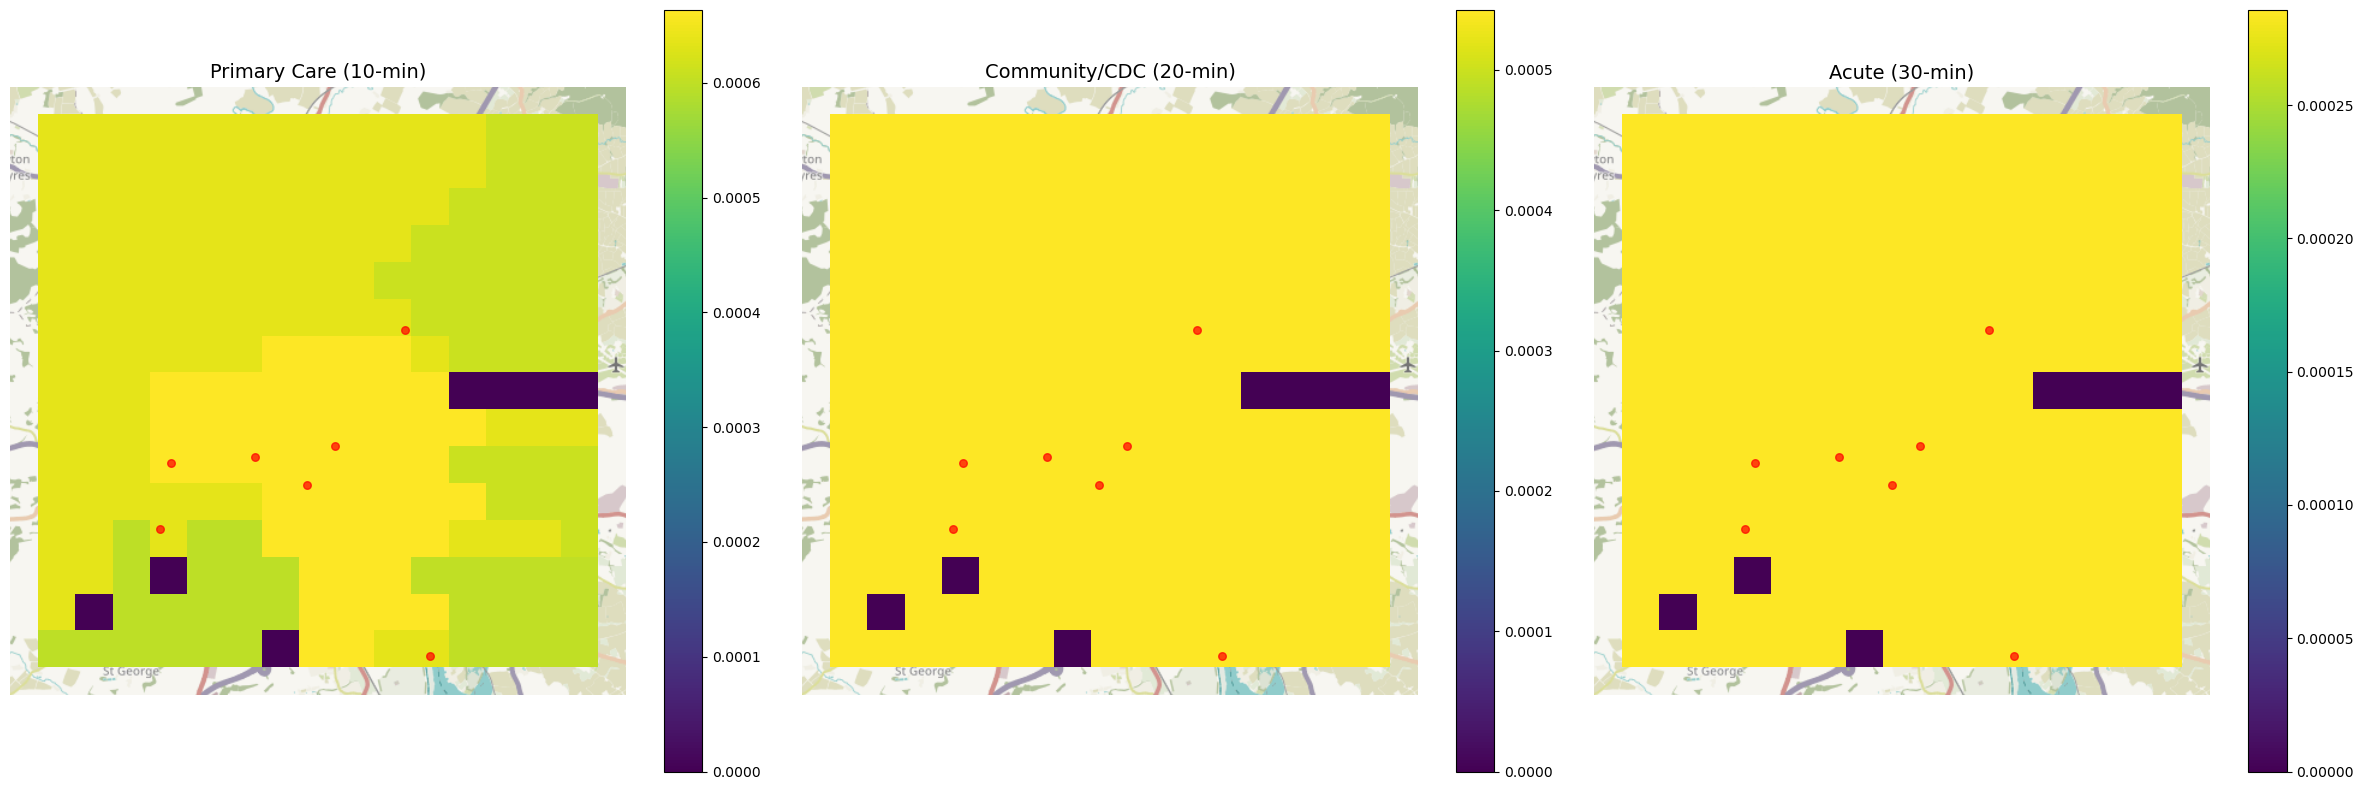

In [6]:
# --- 6. Visualise Tiered Accessibility ---
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

crs_3857 = "EPSG:3857"
titles = ["Primary Care (10‑min)", "Community/CDC (20‑min)", "Acute (30‑min)"]
access_cols = ["access_primary", "access_community", "access_acute"]

for ax, title, col in zip(axes, titles, access_cols):
    lsoa_gdf.to_crs(crs_3857).plot(
        column=col,
        cmap="viridis",
        legend=True,
        ax=ax,
        edgecolor="none"
    )
    facilities_gdf.to_crs(crs_3857).plot(
        ax=ax,
        color="red",
        markersize=30,
        alpha=0.7
    )
    cx.add_basemap(ax, crs="EPSG:3857", attribution=False)
    ax.set_title(title, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()


### 5. Analysis and Conclusion

The 2SFCA method provides a much richer understanding of accessibility than travel time alone.

- **Reveals Hidden Disparities:** An area might appear to have good access because it's close to a facility (low travel time), but if that facility is overwhelmed with demand from a large population, the actual accessibility is low. The 2SFCA score captures this.
- **Highlights Different 'Deserts':** The maps clearly show that an area can be a 'desert' for one type of care but not another. For example, a suburban area might have excellent access to GP practices (Map A) but very poor access to specialized acute care (Map C).
- **Informs Systemic Planning:** This analysis is vital for health service planners. It helps identify not just where to put new facilities, but *what kind* of facilities are needed most in specific areas to ensure equitable access across all tiers of care.

### 6. References and Further Reading

- **Luo, W., & Wang, F. (2003).** *Measures of spatial accessibility to health care in a GIS environment: synthesis and a case study in the Chicago region*. Environment and Planning B: Planning and Design, 30(6), 865-884. One of the foundational papers on the 2SFCA method.
- **Zhao, Y., & Zhou, Y. (2024).** *Isochrone-Based Accessibility Analysis of Pre-Hospital Emergency Medical Facilities*. ISPRS Int. J. Geo-Inf. The concept of assessing equity from the demand side by considering resource competition is central to this paper and the 2SFCA method.
- **Hierarchical Models:** The idea of modeling different tiers of service is common in healthcare and retail analysis. It recognizes that services are not uniform and that higher-order services are typically less numerous and have larger catchment areas.